# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

In [1]:
%env NOTEBOOKNAME try13
%env LOCAL_DATA_PATH data
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try13
env: LOCAL_DATA_PATH=data
env: SUBMISSION_PATH=submission


In [71]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.5.0-dev20201208
tfa.__version__: 0.11.2


/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201208). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Wed Dec 16 21:13:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   37C    P8    19W / 220W |    302MiB /  7979MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       2.4Gi        26Gi       489Mi       2.6Gi        28Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [41]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 10,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Train / Validation**

```
"""Using sklearn.model_selection.train_test_split()"""

tr_df, vl_df = train_test_split(
    df, 
    test_size = args["TEST_SIZE"]
    random_state = args["SEED"])
    
```

In [42]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))

In [43]:
# df.head()

In [44]:
# df.describe()

In [45]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df.shape, vl_df.shape

((42048, 9), (10512, 9))

In [46]:
def preprocessing(df, is_training = True, day = 24 * 60 * 60): # day must be represented by sec
    # Drop timestampes.
    try:
        df = df.drop(["Day"], axis = 1) # cannot use day features
    except:
        pass
    
    
    # Timestamp to sin/cos.
    for column in ["Hour", "Minute"]:
        df[f"_{column}"] = df[column].apply(lambda x: f"{x:0>2d}")
    
    df["Time"] = df[["_Hour", "_Minute"]].apply(lambda x: ":".join(x), axis = 1)
    
    timestamp = pd.to_datetime(df["Time"], format = "%H:%M").map(datetime.datetime.timestamp)
        
    day_sin = np.sin(timestamp * (2 * np.pi / day))
    day_cos = np.cos(timestamp * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "_Hour", "_Minute", "Time"], axis = 1)
    
    
    # Standarize.
    for column in ["DHI", "DNI", "WS", "RH", "T"]: # without DAY_SIN, DAY_COS, TARGET
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

In [47]:
tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

In [48]:
tr_df

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,-0.798985,-0.601350,-0.620599,-0.668244,-0.677079,0.527259,-2.018496,0.0
1,-0.870642,-0.491917,-0.620599,-0.668244,-0.677079,0.526338,-2.018496,0.0
2,-0.927402,-0.374067,-0.620599,-0.668244,-0.608733,0.651615,-2.018496,0.0
3,-0.968293,-0.249817,-0.620599,-0.668244,-0.608733,0.650234,-2.018496,0.0
4,-0.992617,-0.121292,-0.620599,-0.668244,-0.608733,0.809133,-2.018496,0.0
...,...,...,...,...,...,...,...,...
42043,-0.267799,-0.963475,-0.620599,-0.668244,-0.403696,1.003958,-0.138217,0.0
42044,-0.391267,-0.920277,-0.620599,-0.668244,0.074724,1.351695,-0.138217,0.0
42045,-0.508040,-0.861334,-0.620599,-0.668244,0.348107,1.644624,-0.237179,0.0
42046,-0.616120,-0.787652,-0.620599,-0.668244,0.621489,1.719237,-0.237179,0.0


Text(0.5, 1.0, 'Time of day signal')

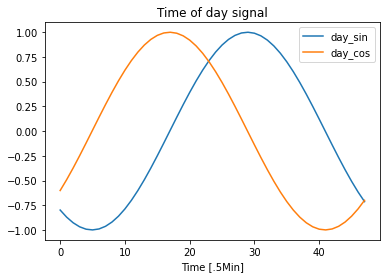

In [91]:
plt.plot(np.array(tr_df["Day_sin"])[:48], label = "day_sin")
plt.plot(np.array(tr_df["Day_cos"])[:48], label = "day_cos")
plt.legend()
plt.xlabel('Time [.5Min]')
plt.title('Time of day signal')

In [92]:
tr_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,42048.000000
mean,3.279092e-13,-1.392590e-13,4.461170e-17,-5.542666e-17,-2.500959e-16,2.893001e-16,7.976031e-17,17.757092
std,7.071152e-01,7.071152e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,25.726194
min,-9.999567e-01,-9.999567e-01,-6.205988e-01,-6.682443e-01,-1.702264e+00,-2.304841e+00,-2.711231e+00,0.000000
25%,-7.037852e-01,-7.037852e-01,-6.205988e-01,-6.682443e-01,-7.454246e-01,-7.605199e-01,-8.309515e-01,0.000000
50%,2.563233e-12,2.563233e-12,-6.205988e-01,-6.682443e-01,-1.986590e-01,4.871736e-02,-1.382169e-01,0.000000
75%,7.037852e-01,7.037852e-01,2.179613e-01,6.501994e-01,4.847981e-01,7.211627e-01,7.524418e-01,31.907314
max,9.999567e-01,9.999567e-01,4.468593e+00,2.353903e+00,6.499220e+00,1.951369e+00,2.632721e+00,99.913939


In [93]:
vl_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,1.051200e+04,1.051200e+04,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,3.279124e-13,-1.392591e-13,-0.002051,0.009001,-0.118357,-0.193249,0.437047,17.924783
std,7.071404e-01,7.071404e-01,1.007151,0.989575,0.862562,1.062334,0.960019,25.895349
min,-9.999567e-01,-9.999567e-01,-0.620599,-0.668244,-1.702264,-2.254638,-1.919534,0.000000
25%,-7.037852e-01,-7.037852e-01,-0.620599,-0.668244,-0.745425,-1.066805,-0.336141,0.000000
50%,2.563233e-12,2.563233e-12,-0.620599,-0.668244,-0.267005,-0.238223,0.455556,0.000000
75%,7.037852e-01,7.037852e-01,0.227600,0.744374,0.416452,0.568941,1.148290,32.659510
max,9.999567e-01,9.999567e-01,4.420400,2.251167,3.902083,1.951369,2.632721,99.453605


## **Test**

In [49]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

In [95]:
ts_df.head()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
0,-0.798985,-0.601350,-0.620599,-0.668244,0.143070,-1.069108,-0.830951,0.0
1,-0.870642,-0.491917,-0.620599,-0.668244,0.143070,-1.080622,-0.821055,0.0
2,-0.927402,-0.374067,-0.620599,-0.668244,0.143070,-1.077859,-0.811159,0.0
3,-0.968293,-0.249817,-0.620599,-0.668244,0.143070,-1.088913,-0.801263,0.0
4,-0.992617,-0.121292,-0.620599,-0.668244,0.211415,-1.089834,-0.791367,0.0


In [96]:
ts_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,2.721600e+04,2.721600e+04,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000
mean,3.279091e-13,-1.392587e-13,-0.051219,0.048407,-0.149449,-0.517592,0.133563,18.235096
std,7.071198e-01,7.071198e-01,0.882946,1.022026,0.869087,0.883242,1.116901,26.115609
min,-9.999567e-01,-9.999567e-01,-0.620599,-0.668244,-1.633919,-2.428276,-2.384656,0.000000
25%,-7.037852e-01,-7.037852e-01,-0.620599,-0.668244,-0.813770,-1.223056,-0.791367,0.000000
50%,2.563233e-12,2.563233e-12,-0.562767,-0.668244,-0.335350,-0.497529,0.030019,0.563069
75%,7.037852e-01,7.037852e-01,0.179407,0.775765,0.279761,0.149584,0.980055,32.557286
max,9.999567e-01,9.999567e-01,4.266182,2.410978,5.815763,1.609159,2.800957,99.450872


# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [50]:
@tf.function
def _split_window(features):
    return tf.split(features, [-1, 1], axis = 0)

In [51]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [52]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [53]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [54]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, units, name):
        super(TARGET_MODEL, self).__init__(name = name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [55]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [7, ], dtype = tf.float32)
    
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)    
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [56]:
tmp = TARGET_MODEL("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [104]:
# tf.keras.utils.plot_model(tmp)

In [105]:
del tmp

## **Compile and Fit**

In [57]:
target_model = TARGET_MODEL(
    model_name = "target_model",
    units = 64)

target_model.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam())

In [58]:
# TensorBoard callback.
log_dir = os.path.join(
    "logs", "fit", os.environ["NOTEBOOKNAME"], 
    datetime.datetime.now().strftime(f"{target_model.name}-%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

history = target_model.fit(
    tr_dataset,
    validation_data = vl_dataset,
    epochs = 500,
    verbose = 0,
    callbacks = [tb_callback])

In [61]:
def draw_history(history):
    
    plt.figure(figsize = (7, 5), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], color = "tomato", label = "loss", alpha = .8)
    plt.plot(history.epoch, history.history["val_loss"], color = "navy", label = "val_loss", alpha = .8)
    
#     plt.ylim(ylim)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss (MAE)")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

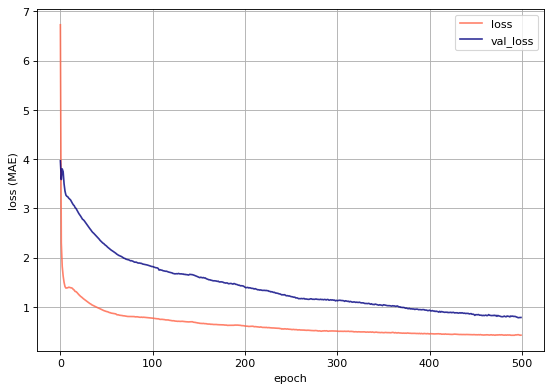

In [62]:
draw_history(history)

In [36]:
# %tensorboard --logdir logs/fit --host jupyter-server

## **Predict**

In [63]:
target_model.evaluate(ts_dataset, verbose = 1)

213/213 [==============================] - 0s 766us/step - loss: 0.9429


0.9428833723068237

# **Phase \#2: AT Model**

## **Make Dataset Pipelines**

In [64]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], tar[..., -1:] # inp: (batch, 336, 7), tar: (batch, 96, 1)


@tf.function
def _split_window_ts(features):
    return features[..., :-1] # (batch, 336, 7)

In [65]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).batch(args["NUM_TEST_CSV"] # Not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [66]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [67]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [68]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [79]:
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, units, name):
        super(TARGET_MODEL, self).__init__(name = name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x           

In [80]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] -> [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_cell = tf.keras.layers.LSTMCell(self.units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        predictions = []
        
        prediction, state = self.warmup(inputs)
        predictions.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = prediction
            # [batch, num_features] => [batch, units]
            x, state = self.lstm_cell(x, states = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            predictions.append(self.target_model(prediction))
            
        predictions = tf.stack(predictions, axis = 1)
        return predictions

## **Compile and Fit**

In [85]:
# target_model.trainable = False # fix the weights
models = []

for tau in np.arange(0.1, 1, 0.1):
    model = AR_LSTM(
        target_model = TARGET_MODEL(units = 64, name = f"T{tau:.1f}"),
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    models.append(model)

In [86]:
for model in models:
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"\nModel {model.name}...\n")
    
    _ = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = args["EPOCH"],
        verbose = 2,
        callbacks = [tb_callback])


Model P0.1...

Epoch 1/10
7/7 - 16s - loss: 1.7854 - val_loss: 1.7643
Epoch 2/10
7/7 - 2s - loss: 1.7850 - val_loss: 1.7641
Epoch 3/10
7/7 - 2s - loss: 1.7849 - val_loss: 1.7642
Epoch 4/10
7/7 - 2s - loss: 1.7849 - val_loss: 1.7640
Epoch 5/10
7/7 - 2s - loss: 1.7848 - val_loss: 1.7641
Epoch 6/10
7/7 - 2s - loss: 1.7849 - val_loss: 1.7644
Epoch 7/10
7/7 - 2s - loss: 1.7852 - val_loss: 1.7640
Epoch 8/10
7/7 - 2s - loss: 1.7851 - val_loss: 1.7646
Epoch 9/10
7/7 - 2s - loss: 1.7852 - val_loss: 1.7640
Epoch 10/10
7/7 - 2s - loss: 1.7851 - val_loss: 1.7645

Model P0.2...

Epoch 1/10
7/7 - 17s - loss: 3.5704 - val_loss: 3.5284
Epoch 2/10
7/7 - 2s - loss: 3.5699 - val_loss: 3.5280
Epoch 3/10
7/7 - 2s - loss: 3.5698 - val_loss: 3.5284
Epoch 4/10
7/7 - 2s - loss: 3.5696 - val_loss: 3.5280
Epoch 5/10
7/7 - 2s - loss: 3.5695 - val_loss: 3.5279
Epoch 6/10
7/7 - 2s - loss: 3.5694 - val_loss: 3.5279
Epoch 7/10
7/7 - 2s - loss: 3.5694 - val_loss: 3.5277
Epoch 8/10
7/7 - 2s - loss: 3.5692 - val_loss: 

In [87]:
%tensorboard --logdir logs/fit --host jupyter-server

## **Predict**

In [88]:
preds = [np.array(model.predict(ts_dataset))[..., 0] for model in models]
preds[0].shape

(81, 96)

In [89]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
#     foo = (foo * args["TARGET_STD"]) + args["TARGET_STD"]
#     foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [91]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-0.021511,-0.000256,0.415983,-0.013518,-0.013992,0.119357,0.185494,1.380376,2.010500
0.csv_Day7_0h30m,-0.015425,0.001286,0.297895,-0.005883,0.002595,0.120345,0.184872,1.632279,2.317418
0.csv_Day7_1h00m,-0.010233,-0.000091,0.173693,-0.002300,0.003090,0.092664,0.154891,1.990723,2.563728
0.csv_Day7_1h30m,-0.007479,-0.003712,0.084966,-0.006668,-0.000983,0.088277,0.111617,2.517275,2.744506
0.csv_Day7_2h00m,-0.006309,-0.005801,0.043601,-0.009268,-0.001920,0.089372,0.078859,3.260755,2.873778


In [92]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))